# Word2Vec для отношения isa

<b>Задача:</b><br> 
Научить сеть воспроизводить расстояния между смыслами, вычисленные на дереве отношения `isa`.

In [23]:
import numpy  as np                                         # работа с массивами
import pandas as pd                                         # таблицы данных  
import matplotlib.pyplot as plt                             # рисование графиков
import time                                                 # время вычислений

from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
from   sklearn.model_selection import train_test_split      # разделение на обучение и тест

## Загружаем данные

In [24]:
df = pd.read_csv('isa.csv')                                 # Загружаем обучающие данные

display(df.head(10))                                        # Выводим первые 10 расстояний
print('Число примеров:',len(df))                   

,sense1,sense2,dist
0,объект,объект,0
1,объект,вещь,1
2,объект,существо,1
3,объект,место,1
4,объект,вещество,1
5,объект,часть,1
6,объект,вещь_рукотворная,2
7,объект,вещь_природная,2
8,объект,животное,2
9,объект,растение,2


Число примеров: 15376


## Кодируем слова целыми числами

При помощи `LabelEncoder` из библиотеки `sklearn` имена смыслов преобразуем в целые числа.<br>
Словарь (смысл, номер) хранится в объекте `le`.


In [25]:
le = LabelEncoder()                               # кодировщик
le.fit(np.hstack([df["sense1"], df["sense2"]]))   # объединяем и нумеруем (могут не пересекаться)

df["s1"] = le.transform(df["sense1"])             # кодируем, добавляя новые колонки
df["s2"] = le.transform(df["sense2"])

df["d"]  = df.dist/df.dist.max()                  # нормируем расстояния на 1

display(df.head())

print("расстояния min:%d max:%d mean:%d" % (df["dist"].min(), df["dist"].max(), df["dist"].mean()))
print("число смыслов: ", df["s1"].nunique(), df["s2"].nunique(), len(le.classes_),"\n")

print(le.classes_)                                # список всех категорий (смыслов)

,sense1,sense2,dist,s1,s2,d
0,объект,объект,0,75,75,0.0
1,объект,вещь,1,75,8,0.1
2,объект,существо,1,75,103,0.1
3,объект,место,1,75,58,0.1
4,объект,вещество,1,75,7,0.1


расстояния min:0 max:10 mean:6
число смыслов:  124 124 124 

['автомобиль' 'акула' 'аппарат' 'арфа' 'баян' 'бутылка' 'велосипед'
 'вещество' 'вещь' 'вещь_природная' 'вещь_рукотворная' 'вишня' 'вода'
 'воздух' 'волынка' 'воробей' 'ворона' 'газета' 'гитара' 'гора' 'город'
 'груша' 'дверь' 'дерево' 'дом' 'еда' 'еда_жидкая' 'еда_твёрдая' 'ель'
 'железо' 'животное' 'звезда' 'зверь' 'золото' 'игла' 'инструмент'
 'инструмент_воздух' 'инструмент_инфо' 'инструмент_музыка'
 'инструмент_работа' 'инструмент_струны' 'камень' 'карась' 'клавиатура'
 'книга' 'комар' 'компьютер' 'контейнер' 'корабль' 'корень' 'кофе' 'кошка'
 'ласточка' 'лестница' 'липа' 'лист' 'лопата' 'медведь' 'место'
 'место_природное' 'место_рукотворное' 'метла' 'мешок' 'молоток' 'монитор'
 'море' 'муравей' 'муха' 'мышка' 'мясо' 'напильник' 'насекомое' 'нитка'
 'нога' 'нос' 'объект' 'окно' 'отвёртка' 'паук' 'пианино' 'пила' 'планета'
 'подснежник' 'пол' 'поле' 'полынь' 'птица' 'ракета' 'растение' 'река'
 'роза' 'рояль' 'рука' 'рыба

## Разбиваем на обучение и валидацию

In [34]:
X_lrn, X_val, y_lrn, y_val = train_test_split(df[["s1","s2"]], df["d"], 
                                              test_size = 0.1, random_state= 137)

print(X_lrn.shape, y_lrn.shape, X_val.shape, y_val.shape)
display(X_lrn.head())

(13838, 2) (13838,) (1538, 2) (1538,)


,s1,s2
7873,34,56
9206,14,67
4267,54,62
9618,17,95
1955,71,89


## Определение модели

In [27]:
from keras.models    import Sequential, load_model                # линейная стопка слоёв, загрузка
from keras.layers    import Dense, Embedding, Flatten, Dropout    # разновидности словёв
from keras.callbacks import ModelCheckpoint                       # сохранение лучшей модели 

In [35]:
NUM_WORDS = len(le.classes_)                                      # число слов (word)
VEC_DIM   = 1                                                     # размерность вектора  

In [36]:
model = Sequential()
model.add(Embedding(NUM_WORDS, VEC_DIM, input_length=2, name="emb"))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense( 1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, 2, 1)              124       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 317
Trainable params: 317
Non-trainable params: 0
_________________________________________________________________


## - Обучение модели

In [37]:
from keras.optimizers import SGD, Adagrad, Adadelta, Adam, Nadam

model.compile(loss="mean_squared_error",   optimizer=Adagrad() )
#model.compile(loss="binary_crossentropy",   optimizer=Adam() )

In [38]:
%%time
file  = "m_E2_D16_D8_D1"
#model = load_model(file)                                              # загружаем сеть из файла

model.fit(X_lrn, y_lrn, epochs=1000, batch_size=10,  verbose=1,
          validation_data=(X_val, y_val),  
          callbacks=[ModelCheckpoint(file,                            # имя файла
                                     monitor='val_loss',              # за чем следим
                                     verbose=1, save_best_only=True)] )

Train on 13838 samples, validate on 1538 samples
Epoch 1/1000
13838/13838 [==============================] - 3s 218us/step - loss: 0.0384 - val_loss: 0.0354

Epoch 00001: val_loss improved from inf to 0.03540, saving model to m_E2_D16_D8_D1
Epoch 2/1000
13838/13838 [==============================] - 3s 204us/step - loss: 0.0342 - val_loss: 0.0348

Epoch 00002: val_loss improved from 0.03540 to 0.03480, saving model to m_E2_D16_D8_D1
Epoch 3/1000
13838/13838 [==============================] - 3s 192us/step - loss: 0.0338 - val_loss: 0.0346

Epoch 00003: val_loss improved from 0.03480 to 0.03460, saving model to m_E2_D16_D8_D1
Epoch 4/1000
13838/13838 [==============================] - 3s 206us/step - loss: 0.0336 - val_loss: 0.0345

Epoch 00004: val_loss improved from 0.03460 to 0.03445, saving model to m_E2_D16_D8_D1
Epoch 5/1000
13838/13838 [==============================] - 3s 191us/step - loss: 0.0335 - val_loss: 0.0343

Epoch 00005: val_loss improved from 0.03445 to 0.03433, saving

Epoch 43/1000
13838/13838 [==============================] - 3s 187us/step - loss: 0.0287 - val_loss: 0.0289

Epoch 00043: val_loss improved from 0.02901 to 0.02892, saving model to m_E2_D16_D8_D1
Epoch 44/1000
13838/13838 [==============================] - 3s 188us/step - loss: 0.0286 - val_loss: 0.0289

Epoch 00044: val_loss improved from 0.02892 to 0.02886, saving model to m_E2_D16_D8_D1
Epoch 45/1000
13838/13838 [==============================] - 3s 189us/step - loss: 0.0285 - val_loss: 0.0288

Epoch 00045: val_loss improved from 0.02886 to 0.02876, saving model to m_E2_D16_D8_D1
Epoch 46/1000
13838/13838 [==============================] - 3s 189us/step - loss: 0.0284 - val_loss: 0.0287

Epoch 00046: val_loss improved from 0.02876 to 0.02872, saving model to m_E2_D16_D8_D1
Epoch 47/1000
13838/13838 [==============================] - 3s 186us/step - loss: 0.0283 - val_loss: 0.0287

Epoch 00047: val_loss improved from 0.02872 to 0.02866, saving model to m_E2_D16_D8_D1
Epoch 48/1000
1

Epoch 85/1000
13838/13838 [==============================] - 3s 200us/step - loss: 0.0233 - val_loss: 0.0249

Epoch 00085: val_loss improved from 0.02496 to 0.02491, saving model to m_E2_D16_D8_D1
Epoch 86/1000
13838/13838 [==============================] - 3s 199us/step - loss: 0.0232 - val_loss: 0.0248

Epoch 00086: val_loss improved from 0.02491 to 0.02484, saving model to m_E2_D16_D8_D1
Epoch 87/1000
13838/13838 [==============================] - 3s 205us/step - loss: 0.0231 - val_loss: 0.0248

Epoch 00087: val_loss improved from 0.02484 to 0.02479, saving model to m_E2_D16_D8_D1
Epoch 88/1000
13838/13838 [==============================] - 3s 206us/step - loss: 0.0230 - val_loss: 0.0247

Epoch 00088: val_loss improved from 0.02479 to 0.02470, saving model to m_E2_D16_D8_D1
Epoch 89/1000
13838/13838 [==============================] - 3s 203us/step - loss: 0.0230 - val_loss: 0.0247

Epoch 00089: val_loss improved from 0.02470 to 0.02466, saving model to m_E2_D16_D8_D1
Epoch 90/1000
1

KeyboardInterrupt: 

In [ ]:
"""
m_E2_D4_D2_D1     loss: 0.0054       val_loss: 0.0062       |err|: 0.0471
m_E2_D4_D4_D1     loss: 0.0011       val_loss: 0.0010       |err|: 0.0229
m_E2_D8_D4_D1     loss: 0.0060       val_loss: 0.0067       |err|: 0.0540
m_E2_D8_D4_D1     loss: 4.7979e-04   val_loss: 5.4693e-04   |err|: 0.0141    

m_E5_D16_D10_D1   loss: 3.7722e-05   val_loss: 9.5386e-05   |err|: 0.0032
 
m_E5_D10_D5_D1    loss: 2.4075e-04   val_loss: 5.1101e-04   |err|: 0.0110
m_E3_D10_D5_D1    loss: 4.8165e-04   val_loss: 5.0517e-04   |err|: 0.0134 
m_E2_D10_D5_D1    loss: 5.6848e-04   val_loss: 5.9667e-04   |err|: 0.0135
m_E2_D20_D10_D1   loss: 4.2740e-04 - val_loss: 5.9832e-04   |err|: 0.0130
 
m_E5_D10_D1       loss: 0.0016       val_loss: 0.0021       |err|: 0.0251
 
m_E2_D16_D10_D1   loss: 0.0017       val_loss: 0.0018       |err|: 0.027
"""

## Загружаем модель    

In [20]:
model = load_model("m_E2_D16_D8_D1_")

## Тестируем

In [39]:
y_res = model.predict(X_val)                               # результаты работы сети
y_res = y_res.reshape(len(y_res),)
print("err: %.4f\n" % ( np.mean(np.abs(y_res - y_val)) ))  # отклонение по модулю

# получить id смысла s
def s2id(s):
    return le.transform([s])[0]
        
# выводим расстояние между словами s1,s2 из исходных данных и по предсказанию сети:
def dist(s1, s2):
    d1 = df['d'][ (df['s1'] == s2id(s1) ) & (df['s2'] == s2id(s2)) ].values[0]
    d2 = model.predict(np.array([[s2id(s1), s2id(s2) ]] ))[0][0]
    print("%-8s %-8s | dist:%5.3f, pred:%5.3f, err:%6.3f" % (s1, s2, d1, d2, d1-d2))

dist("кошка", "баян")
dist("книга", "молоток")
dist("кошка", "собака")

err: 0.1068

кошка    баян     | dist:1.000, pred:0.899, err: 0.101
книга    молоток  | dist:0.400, pred:0.550, err:-0.150
кошка    собака   | dist:0.200, pred:0.585, err:-0.385


In [14]:
df['res'] = model.predict(df[['s1','s2']])               # результаты работы сети для всей таблицы
df['err'] = np.abs(df.res - df.d)                        # отклонение по модулю
df.err.describe()                                        # статитики

count    15376.000000
mean         0.008167
std          0.015193
min          0.000000
25%          0.001636
50%          0.004137
75%          0.008272
max          0.232137
Name: err, dtype: float64

## Компоненты векторов

Вектора, соответствующие каждому слову находятся в слое с именем `emb`

In [41]:
vectors = model.get_layer('emb').get_weights()[0]       # веса Embedding слоя

np.set_printoptions(precision=3, suppress=True)         # формат вывода np-массивов  

i = 0                                                   # выводим первые 10 векторов
for v in vectors:
    print(v, le.inverse_transform([i])[0])              # из номера получаем слово
    i += 1
    if i > 100:
        break

[-0.056] автомобиль
[ 0.144] акула
[-0.096] аппарат
[ 0.002] арфа
[ 0.002] баян
[-0.055] бутылка
[-0.056] велосипед
[-0.159] вещество
[-0.277] вещь
[-0.121] вещь_природная
[-0.267] вещь_рукотворная
[ 0.145] вишня
[-0.116] вода
[-0.116] воздух
[ 0.002] волынка
[ 0.144] воробей
[ 0.145] ворона
[-0.012] газета
[ 0.001] гитара
[ 0.124] гора
[ 0.125] город
[-0.002] груша
[ 0.134] дверь
[-0.132] дерево
[ 0.124] дом
[-0.095] еда
[-0.058] еда_жидкая
[-0.058] еда_твёрдая
[ 0.144] ель
[-0.116] железо
[-0.142] животное
[-0.089] звезда
[-0.137] зверь
[-0.117] золото
[-0.01] игла
[-0.194] инструмент
[-0.014] инструмент_воздух
[-0.061] инструмент_инфо
[-0.06] инструмент_музыка
[-0.059] инструмент_работа
[-0.015] инструмент_струны
[-0.09] камень
[ 0.145] карась
[-0.01] клавиатура
[-0.012] книга
[ 0.144] комар
[-0.013] компьютер
[-0.096] контейнер
[-0.057] корабль
[ 0.151] корень
[-0.002] кофе
[ 0.144] кошка
[ 0.144] ласточка
[ 0.132] лестница
[ 0.145] липа
[ 0.15] лист
[-0.011] лопата
[ 0.144] медвед

## Косинус между векторами

In [16]:
def s2v(s):
    return vectors[s2id(s)];
    
def mult(s1, s2):
    v1   = s2v(s1); v2 = s2v(s2)
    cos  = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    dist = np.linalg.norm(v1-v2)
    print("%-8s %-8s  cos:%6.3f dist:%6.3f" % (s1, s2, cos, dist ))
        
mult("кошка",  "собака")
mult("кошка",  "акула") 
mult("кошка",  "животное") 
mult("кошка",  "книга")
mult("баян",   "скрипка") 
mult("баян",   "роза") 
mult("окно",   "рука") 
mult("дерево", "тополь") 
mult("яблоня", "тополь") 

кошка    собака    cos: 1.000 dist: 0.087
кошка    акула     cos: 1.000 dist: 0.258
кошка    животное  cos: 0.934 dist: 0.969
кошка    книга     cos:-0.995 dist: 3.943
баян     скрипка   cos: 1.000 dist: 0.137
баян     роза      cos:-0.950 dist: 3.633
окно     рука      cos: 0.902 dist: 0.451
дерево   тополь    cos: 0.948 dist: 0.501
яблоня   тополь    cos: 1.000 dist: 0.003


In [22]:
# ближайший смысл к вектору vec
def near(vec):
    dist2 = np.sum((vectors - vec)**2, axis=1)
    return le.classes_[np.argmin(dist2)]

v = 0.5*(s2v("гитара")+s2v("арфа"))
near(v)

'пианино'

## 2D-пространство векторов

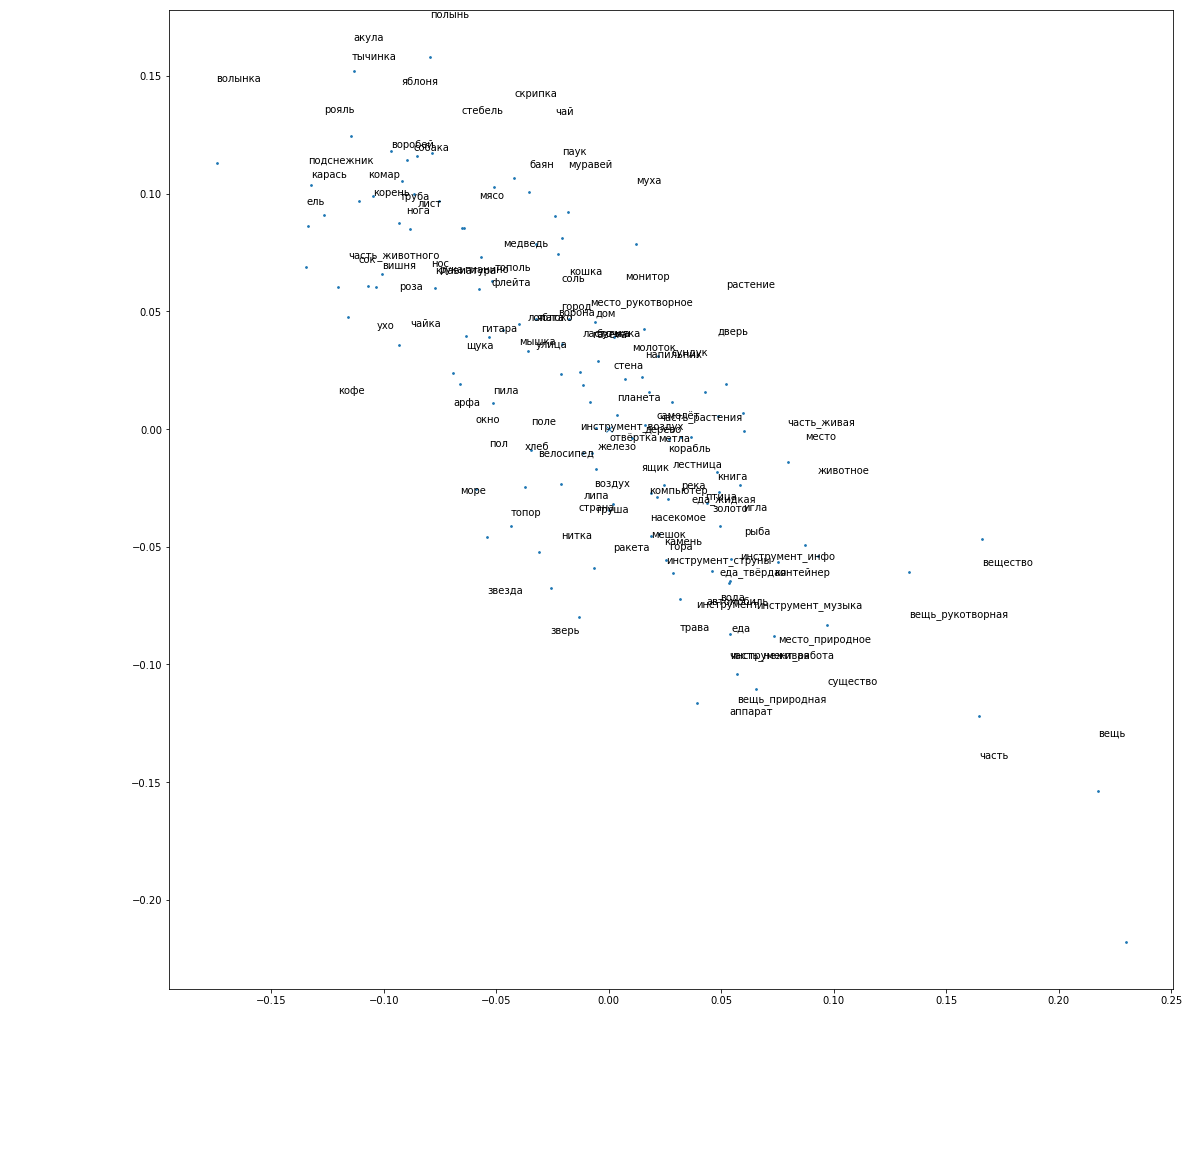

In [33]:
vectors = model.get_layer('emb').get_weights()[0]        # веса Embedding слоя

dat   = np.transpose(vectors)

shift = 0.05*np.random.uniform(-1,1, (len(le.classes_)))
fig, ax = plt.subplots(figsize=(18, 18))
plt.scatter(dat[0], dat[1], s=3)
plt.plot(0,0, marker="x")

for i in range(len(le.classes_)):
    ax.annotate(le.classes_[i], (dat[0][i], dat[1][i]+shift[i]))

plt.show()

## Использование готовых векторов

Можно использовать уже готовые векторы, которые полученые другим способом.<br>
Например:https://nlp.stanford.edu/projects/glove/

См. подробности в https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [ ]:
Embedding(NUM_WORDS, VEC_DIM, input_length=2, weights=[embedding_matrix], trainable=False)

## Функциональное определение модели

Может быть несколько категориальных признаков с различными словарями.<br>
Для каждого такого признака необходим свой Embedding слой<br>
Кроме этого возможны и числовые признаки.<br>

Поэтому сделаем архитектуру в которой на каждый вход подаётся отдельный массив.<br>
Для этого преобразуем входные данные в структуру, содержащую эти массивы:

In [ ]:
def get_keras_data(df):
    return {
        's1': df['s1'].values,
        's2': df['s2'].values
    }    

X_lrn_ = get_keras_data(X_lrn)  # обучение
X_val_ = get_keras_data(X_val)  # валидация

Модель построим в функциональной форме

In [ ]:
from keras.models import Model
from keras.layers import Dropout, Dense, concatenate, Embedding, Flatten, Activation, Input

s1   = Input(shape=[1], name="s1")   # вход с номерами первого слова
s2   = Input(shape=[1], name="s2")   # вход с номерами второго слова

# Номер каждого слова преобразуется в 5-мерный вектор:
emb  = Embedding(input_dim = NUM_WORDS, output_dim = VEC_DIM)

e1   = emb(s1)  # компоненты вектора первого слова
e2   = emb(s2)  # компоненты вектора второго слова

# Соединяем эти компоненты в линейную колбасу размернотси 2*VEC_DIM
main = concatenate([Flatten()(e1), Flatten()(e2)], name="concat" )

# Делаем два скрытых слоя и один нейрон на выходе
#main = Dense(20, kernel_initializer='normal', activation="relu", name="dense1")(main)
main = Dense(10, kernel_initializer='normal', activation="relu", name="dense2")(main)
out  = Dense(  1, activation="sigmoid", name="out") (main)

model = Model([s1, s2], out)
model.summary()

Обучение модели

In [ ]:
from keras.optimizers import SGD, Adagrad, Adadelta, Adam, Nadam

#optimizer  = Adagrad()
optimizer  = Adam()
model.compile(loss="mean_squared_error",   optimizer=optimizer )
#model.compile(loss="binary_crossentropy",   optimizer=optimizer )

In [ ]:
%%time
model.fit(X_lrn_, y_lrn, epochs=1000, batch_size=10,  verbose=1,
          validation_data=(X_val_, y_val),  
          callbacks=[ModelCheckpoint("m",                             # имя файла
                                     monitor='val_loss',              # за чем следим
                                     verbose=1, save_best_only=True)]
)

## Полезные ссылки

<ul>
<li><a href="https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/">
Python: категориальные признаки
</a>
    
<li><a href="https://habr.com/company/ods/blog/326418/">
Открытый курс машинного обучения    
</a>

<li><a href="https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/">
How to Use Word Embedding Layers for Deep Learning with Keras
</a>

<li><a href="http://adventuresinmachinelearning.com/word2vec-keras-tutorial/">
A Word2Vec Keras tutorial
</a>
    
<li><a href="https://nlp.stanford.edu/projects/glove/">
GloVe: Global Vectors for Word Representation    
</a>    
</ul>